In [1]:
import torch

print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("CUDA device count:", torch.cuda.device_count())
    print("Current device:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("No CUDA device detected.")


Torch version: 2.5.1+cu121
CUDA available: True
CUDA device count: 1
Current device: 0
Device name: NVIDIA GeForce RTX 4060 Laptop GPU


In [2]:
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image

# from model.networks_tf import Generator
from model.networks import Generator

plt.rcParams['figure.facecolor'] = 'white'

## Load generator model


In [3]:
use_cuda_if_available = True
device = torch.device('cuda' if torch.cuda.is_available() and use_cuda_if_available else 'cpu')

# sd_path = 'pretrained/states_tf_places2.pth'
generator = Generator().to(device)
state_dict = torch.load("checkpoints/epochs-1-to-10/dfv2_generator_epoch_5.pth")
generator.load_state_dict(state_dict)

print(device)

cuda


C:\Users\CNash\AppData\Local\Temp\ipykernel_14724\1645217212.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("checkpoints/epochs-1-to-10/dfv2_gen

## Load image and mask


In [4]:
n = 1
image_path = f"examples/inpaint/cracked-portrait.jpg"
mask_path = f"examples/inpaint/cracked-portrait-mask.png"

image_pil = Image.open(image_path)
mask_pil = Image.open(mask_path)

## Plot raw image and mask


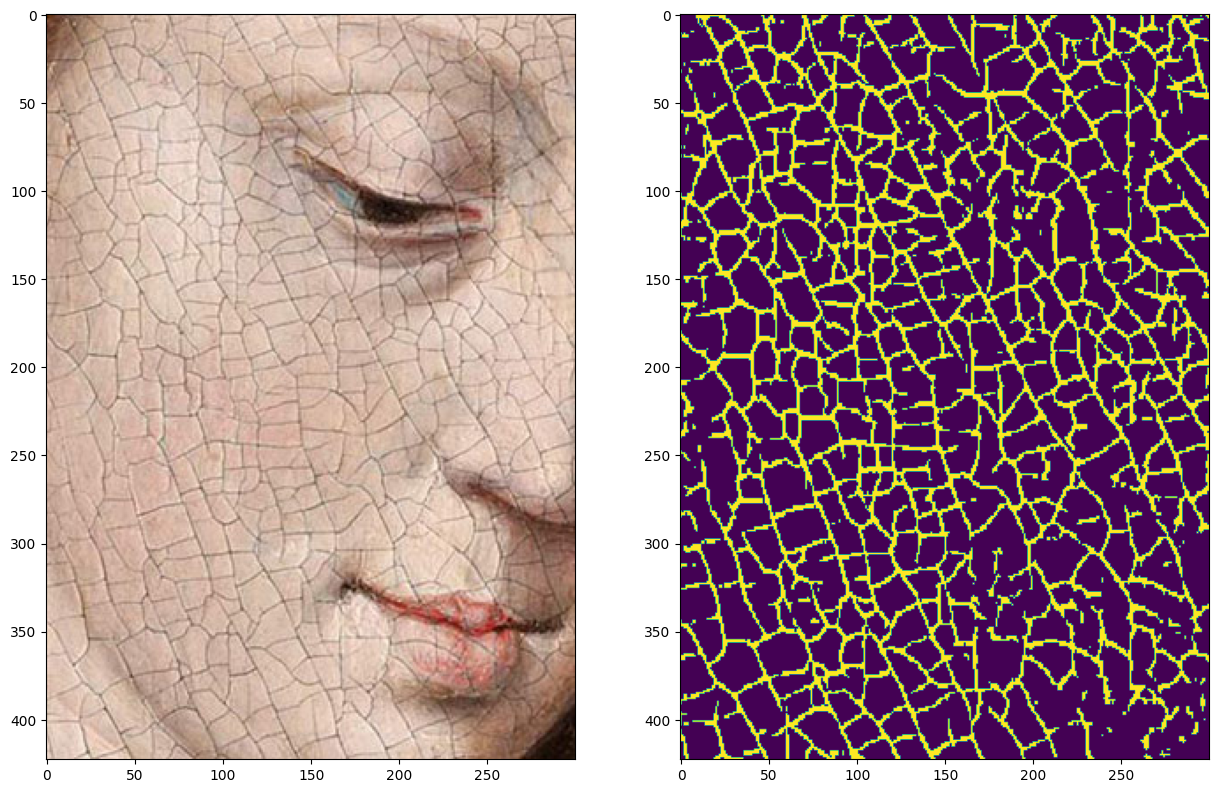

In [5]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
ax1.imshow(image_pil)  # plot raw image
ax2.imshow(mask_pil.convert('L'))   # plot mask
plt.show()

## Inpaint

In [6]:
image = T.ToTensor()(image_pil).to(device)
mask = T.ToTensor()(mask_pil).to(device)

output = generator.infer(image, mask, return_vals=['inpainted', 'stage1', 'stage2'])


## Results


Result:


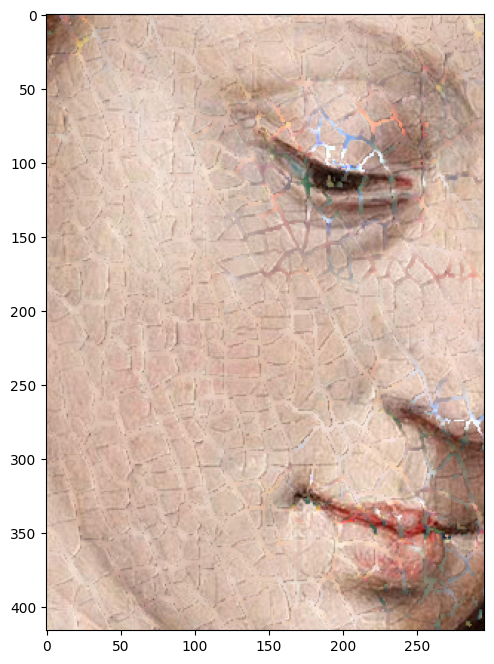

In [7]:
mask = (mask[0:1] > 0.).to(dtype=torch.float32)
image_masked = (image*(1-mask)).permute(1, 2, 0).cpu()

print("Result:")
plt.figure(figsize=(10, 8))
plt.imshow(output[0])
plt.show()

# w, h = image_pil.size

# print("""| Raw | Masked |
# | Stage1 | Stage2 |""")
# _, axes = plt.subplots(2, 2, figsize=(15*w / max(w,h), 15*h / max(w,h)))
# axes[0,0].imshow(image_pil)
# axes[0,1].imshow(image_masked)
# # axes[1,0].imshow(output[1])
# # axes[1,1].imshow(output[2])
# plt.show()

### Plot random images from test set

In [8]:
import os
import time
import csv
from pathlib import Path
import random
import glob

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T
from torchvision.utils import save_image
from tqdm import tqdm

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from model.networks import Generator, Discriminator
import model.losses as gan_losses  # Your GAN losses module

In [9]:
config = {
    "data_root": "data/inpainting-dataset",
    "img_size": (256, 256),
    "batch_size": 1,
    "max_epochs": 10, # originally 10
    "patience": 2, # originally 3
    "g_lr": 1e-4,
    "d_lr": 1e-4,
    "l1_loss_alpha": 1.0,
    "gan_loss_alpha": 0.001,
    "num_workers": 0,
    "pin_memory": False,
    "checkpoint_dir": "checkpoints/",
    "metrics_log": "metrics.csv",
}
os.makedirs(config["checkpoint_dir"], exist_ok=True)


In [10]:
class InpaintingDataset(Dataset):
    def __init__(self, img_dir, mask_dir, img_size):
        self.img_dir = Path(img_dir)
        self.mask_dir = Path(mask_dir)
        self.image_files = []
        self.mask_files = []

        # Filter for valid image-mask pairs
        all_imgs = sorted(list(Path(img_dir).glob("*.jpg")))
        for img_path in all_imgs:
            img_name = img_path.name
            if img_name.endswith("no.jpg"):
                continue
            base = img_name.replace(".jpg", "")
            mask_path = self.mask_dir / f"{base}-mask.png"
            if mask_path.exists():
                self.image_files.append(img_path)
                self.mask_files.append(mask_path)

        self.transform_img = T.Compose([
            T.Resize(img_size),
            T.ToTensor(),
        ])
        self.transform_mask = T.Compose([
            T.Resize(img_size),
            T.ToTensor(),
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img = Image.open(self.image_files[idx]).convert("RGB")
        mask = Image.open(self.mask_files[idx]).convert("L")
        return self.transform_img(img), self.transform_mask(mask)


In [11]:
# Paths
test_img_dir = os.path.join(config["data_root"], "test", "img")
test_mask_dir = os.path.join(config["data_root"], "test", "mask")

# Datasets
test_dataset = InpaintingDataset(test_img_dir, test_mask_dir, config["img_size"])

# Loaders
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False,
                         num_workers=config["num_workers"], pin_memory=True)

In [12]:
import torch
import matplotlib.pyplot as plt

def show_test_examples(generator, loader, device, num_examples=5):
    generator.eval()
    shown = 0

    with torch.no_grad():  # ✅ Point 3: Wrap inference in no_grad
        for imgs, masks in loader:
            imgs = imgs.to(device)
            masks = masks.to(device).float()

            # Prepare input
            incomplete = imgs * (1 - masks)
            ones_x = torch.ones_like(incomplete[:, 0:1])
            x = torch.cat([incomplete, ones_x, ones_x * masks], dim=1)

            # Forward pass
            _, x2 = generator(x, masks)
            output = x2 * masks + incomplete * (1 - masks)

            # Show/save per sample
            for i in range(imgs.size(0)):
                if shown >= num_examples:
                    return

                fig, axes = plt.subplots(1, 3, figsize=(12, 4))
                axes[0].imshow(imgs[i].permute(1, 2, 0).cpu().numpy())
                axes[0].set_title("Original")
                axes[1].imshow(incomplete[i].permute(1, 2, 0).cpu().numpy())
                axes[1].set_title("Masked Input")
                axes[2].imshow(output[i].permute(1, 2, 0).cpu().numpy())
                axes[2].set_title("Restored")

                plt.show()

                # ✅ Point 4: Manually delete and clear memory
                del fig, axes
                torch.cuda.empty_cache()

                shown += 1


In [13]:
torch.cuda.empty_cache()

In [14]:
print(f"Total image-mask pairs in test dataset: {len(test_dataset)}")

Total image-mask pairs in test dataset: 3934


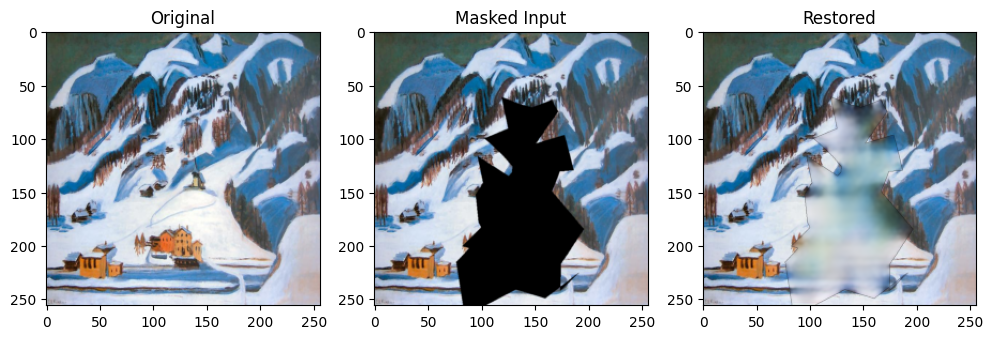

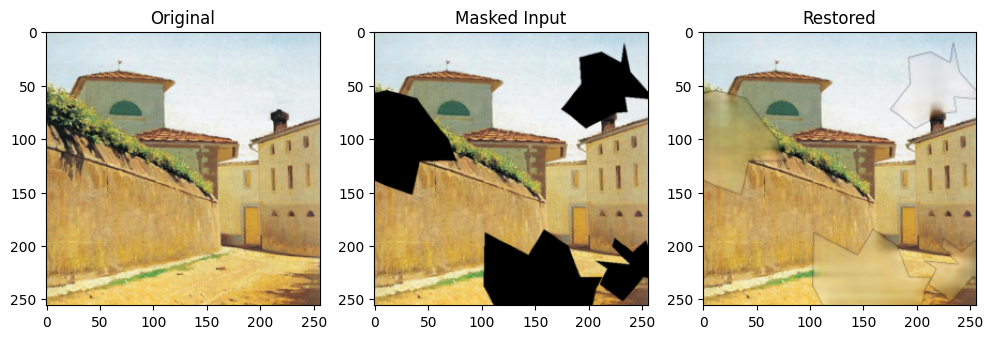

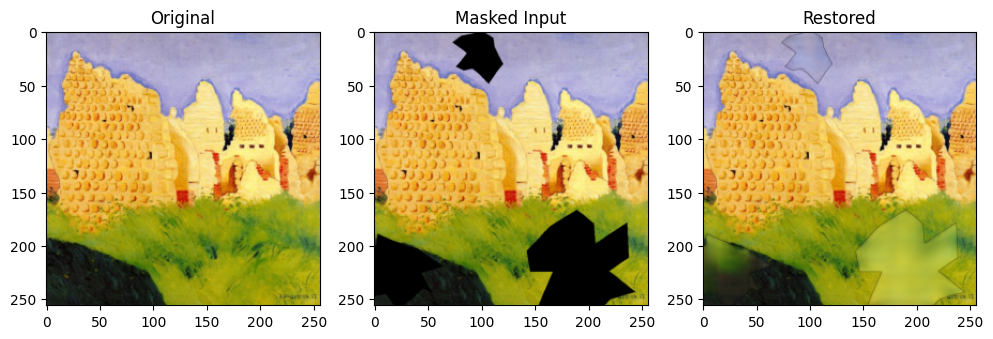

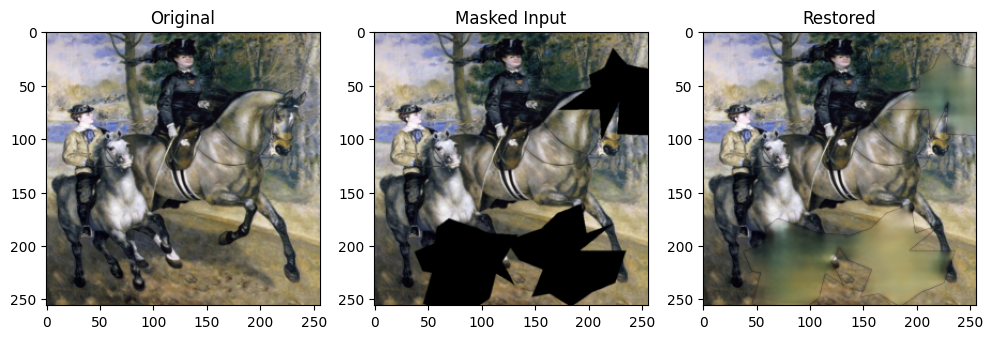

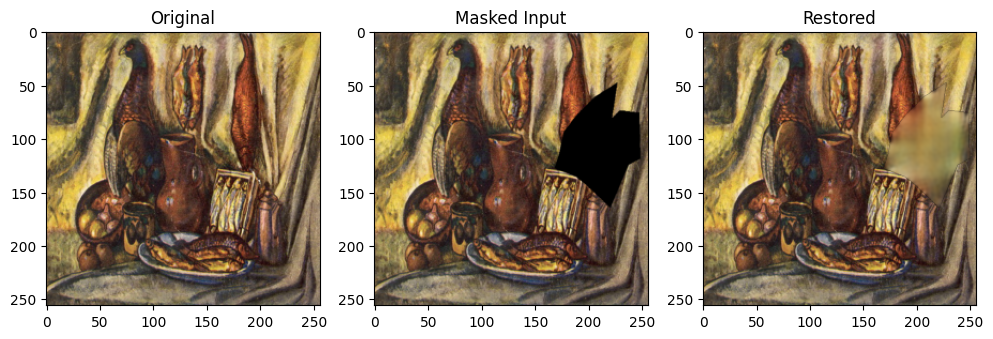

In [15]:
show_test_examples(generator, test_loader, device, num_examples=5)

## Evaluation Metrics

In [16]:
import torch
import numpy as np
import tqdm
from skimage.metrics import structural_similarity as ssim_score
from skimage.metrics import peak_signal_noise_ratio as psnr_score

In [17]:
# Evaluation function
def evaluate_inpainting(model, dataloader, device, max_samples=None):
    psnr_list, ssim_list = [], []
    model.eval()

    with torch.no_grad():
        for i, batch in enumerate(tqdm.tqdm(dataloader, desc="Evaluating")):
            if max_samples and i * dataloader.batch_size >= max_samples:
                break

            original, mask = batch  # expected shape: original (B, 3, H, W), mask (B, 1, H, W)
            original = original.to(device)
            mask = mask.to(device)

            # Synthesize damaged input
            damaged = original * (1 - mask)

            # Prepare input to model (assumes 5-channel input)
            ones_x = torch.ones_like(damaged[:, :1])  # shape: (B, 1, H, W)
            x = torch.cat([damaged, ones_x, ones_x * mask], dim=1)

            # Run model
            _, output = model(x, mask)  # output: (B, 3, H, W)

            # Calculate metrics per image
            for j in range(original.size(0)):
                orig_np = original[j].cpu().permute(1, 2, 0).numpy()
                out_np = output[j].cpu().permute(1, 2, 0).numpy()

                # Convert to uint8 for metric calculation
                orig_np = (orig_np * 255).clip(0, 255).astype(np.uint8)
                out_np = (out_np * 255).clip(0, 255).astype(np.uint8)

                psnr = psnr_score(orig_np, out_np, data_range=255)
                ssim = ssim_score(orig_np, out_np, channel_axis=-1, data_range=255)

                psnr_list.append(psnr)
                ssim_list.append(ssim)

    avg_psnr = np.mean(psnr_list)
    avg_ssim = np.mean(ssim_list)
    return avg_psnr, avg_ssim

In [18]:
# Run evaluation
psnr, ssim = evaluate_inpainting(generator, test_loader, device)
print(f"Average PSNR: {psnr:.2f}")
print(f"Average SSIM: {ssim:.4f}")

Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████| 3934/3934 [02:40<00:00, 24.47it/s]

Average PSNR: 25.95
Average SSIM: 0.7933
